Learn iterator for multiphase problems using PAC-FEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

Test PAC-FEANet for thermal problems 

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train = False # True or False
model_name = 'thermal_type2_2phase_33x33_attention_linear'
training_set = ThermalDataSet('data/thermal/thermal_type2_nphase_33x33_small.h5', device)
model_dir = 'model/learn_iterator/thermal_type2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

nb_layers = 3
bs = 10
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

In [4]:
n_test = 2**5
test_set = ThermalDataSet('data/thermal/thermal_type2_2phase_33x33.h5', device)

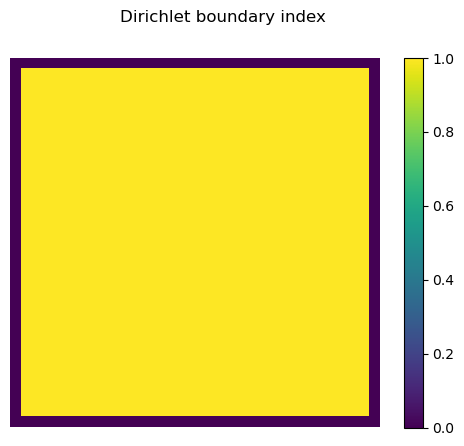

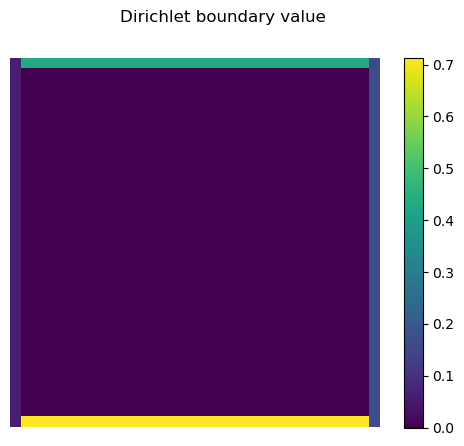

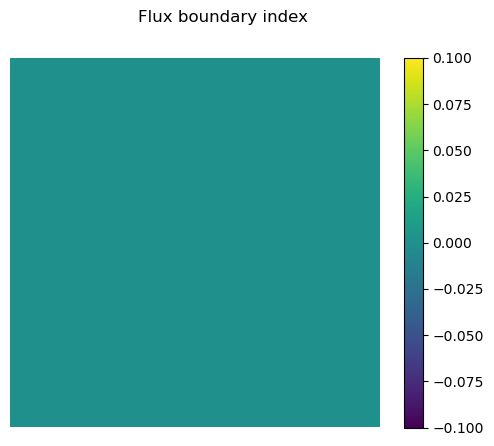

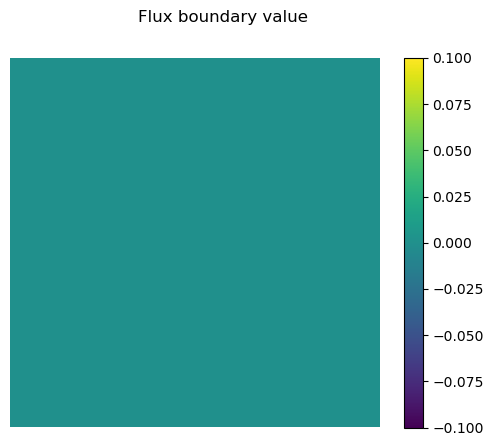

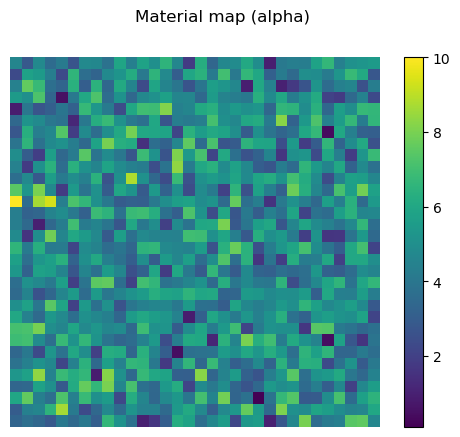

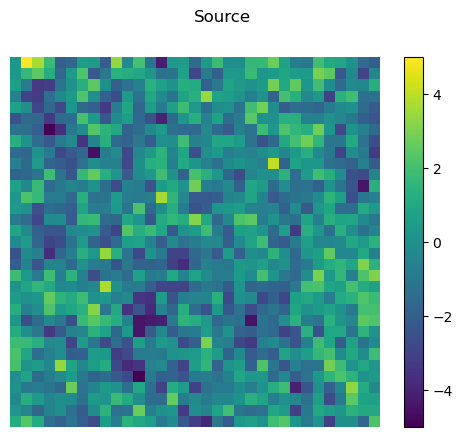

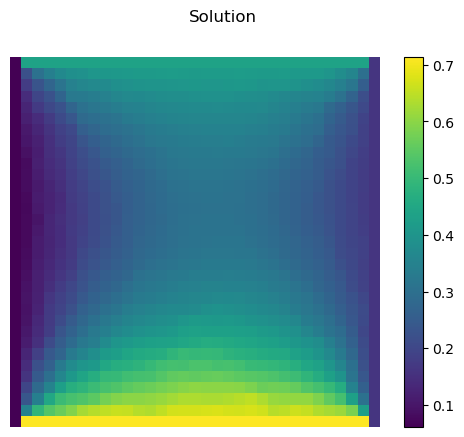

''

In [5]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')

plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')
''''''

In [6]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [7]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [8]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 37.46462047420486
1 20.878299755959834
2 15.085076891345462
3 12.055860165003594
4 10.159104028901064
5 8.841804754879556
6 7.863841153506035
7 7.103441808601521
8 6.491975696946865
9 5.987664264207317
10 5.563506977521096
11 5.201187602477706
12 4.887772854503653
13 4.61381987344821
14 4.372238633418018
15 4.1575793797116996
16 3.9655697223686794
17 3.792803989981687
18 3.6365286411948134
19 3.494490167190719
20 3.3648247985327546
21 3.24597689462305
22 3.1366374686890803
23 3.0356971433980062
24 2.9422096429198086
25 2.855363108074964
26 2.7744573080923223
27 2.698885357506924
28 2.6281189172863786
29 2.5616961203706072
30 2.499211648712352
31 2.4403085246672145
32 2.3846712795361356
33 2.3320202365788987
34 2.282106702013572
35 2.234708900352728
36 2.189628523402085
37 2.1466877878630006
38 2.1057269165454993
39 2.0666019740369386
40 2.0291830002605074
41 1.9933523954284682
42 1.9590035179976115
43 1.9260394637884588
44 1.8943719997568031
45 1.8639206302552724
46 1.834611777188340

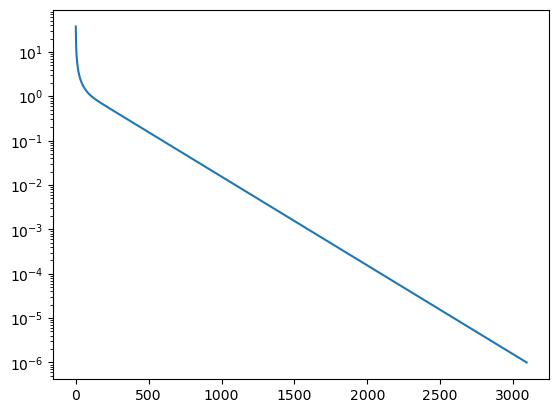

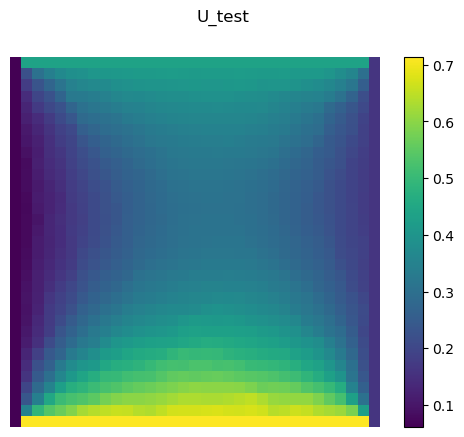

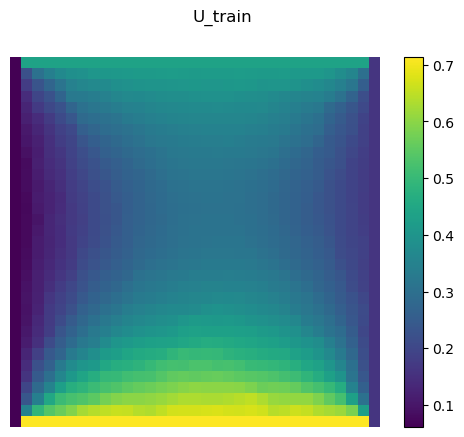

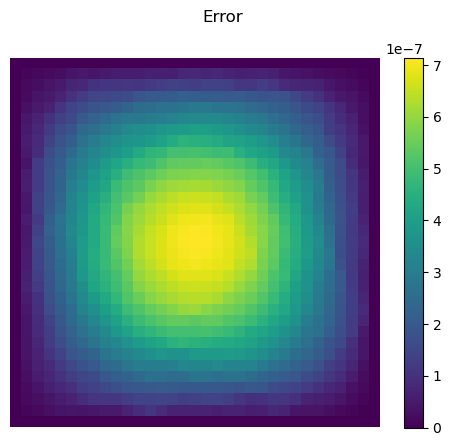

In [9]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [10]:
class AttentionHNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(AttentionHNet, self).__init__()

        self.mode = mode
        self.k_size = 3
        self.nb_layers = nb_layers
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, self.k_size*self.k_size, kernel_size=self.k_size//2),
            #nn.BatchNorm2d(self.k_size*self.k_size)
            )
        #self.nonlinear = nn.Tanh()

        self.pac_smoother = nn.ModuleList([pac.PacConv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, m, dirich_idx):
        '''
        x: error between Jacobi solution and initial guess 
        smoother: learned smoother (Psi) network '''

        bs0, ku0, h0, w0 = x.size()
        
        # get the material kernels
        attention_kernels = self.attention_map(m)
        kernels = attention_kernels.view(bs0, 1, self.k_size, self.k_size, h0, w0) # shape (bs, 1, 3, 3, h, w)
        #kernels = self.nonlinear(attention_kernels).view(bs0, 1, self.k_size, self.k_size, h0, w0) # shape (bs, 1, 3, 3, h, w)

        new_x = x.clone()
        for i in range(self.nb_layers):
            new_x = self.pac_smoother[i](new_x, None, kernels)
            new_x = new_x*dirich_idx # error at dirichlet boundary is zero

        return new_x.clone()

In [11]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 att_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(att_net is None):
            self.att_net = AttentionHNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.att_net = att_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.att_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.att_net(jac_it-u, m, d_idx) 
        return u.clone()

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            self.att_net.train()
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.att_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [12]:
max_epochs = 500
att_net = AttentionHNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_iterator = PsiIterator(device, batch_size=bs, mode='thermal', att_net=att_net, nb_layers=nb_layers, max_epochs=max_epochs)

loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


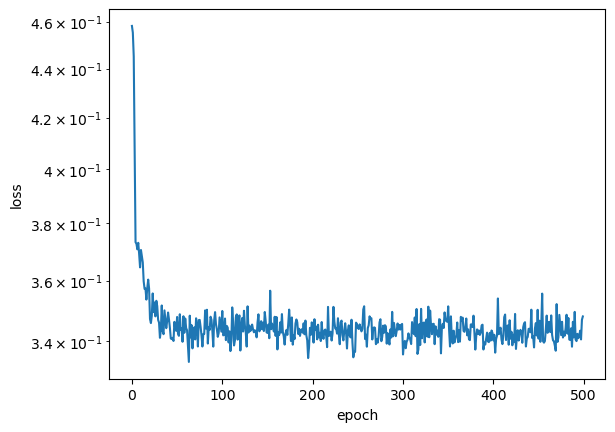

In [13]:
# import the learned model and loss train
new_iterator = PsiIterator(device_predict, att_net=att_net, nb_layers=nb_layers, grid=grid, batch_size=1)
new_iterator.att_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 37.46462047420486
1 14.595126741680545
2 7.93797137420988
3 5.175978629263426
4 3.839766033983309
5 3.0884125773299513
6 2.6158532905940155
7 2.288414165397143
8 2.0465555604023673
9 1.8589944057240397
10 1.7084966199168954
11 1.5845958852767088
12 1.480606709604061
13 1.3919817707757685
14 1.3154859102601097
15 1.2487199902234352
16 1.1898508088299036
17 1.1374455319463466
18 1.0903673562636742
19 1.0477054112942452
20 1.0087254908067151
21 0.9728336623916111
22 0.9395484446661614
23 0.9084789577905666
24 0.8793074887136805
25 0.8517754456265665
26 0.8256719938081858
27 0.800824847890526
28 0.7770928146104422
29 0.7543597611893988
30 0.7325297451507415
31 0.7115230888555845
32 0.6912732207016634
33 0.6717241368711006
34 0.6528283640919649
35 0.6345453259677997
36 0.616840033725179
37 0.5996820373059414
38 0.5830445850913804
39 0.5669039506295067
40 0.5512388929275746
41 0.5360302234998277
42 0.5212604587065098
43 0.5069135402204573
44 0.4929746099091128
45 0.47942982818497504
46 0.4

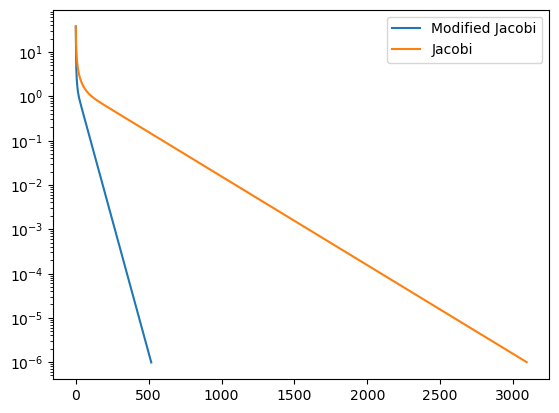

In [14]:
EPS = 1e-6
att_net.eval()
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS and n_new < 5000):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

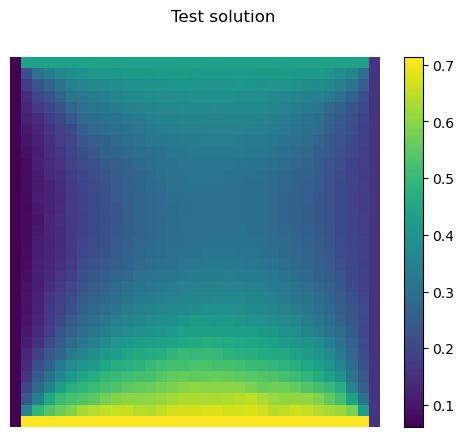

In [15]:
plot.plot_thermalfield(u_test[0], 'Test solution')

In [16]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [17]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, attnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.attnet = attnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.attnet.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, att_net=self.attnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        kernel_m = torch.ones((self.km,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.conv2d(self.p_arr[i]['m'], kernel_m, stride=2, groups=self.km)
            #prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [18]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 1.6908836206466953
1 0.9760965832245252
2 0.7316239920742796
3 0.6043812571002696
4 0.5255580964820327
5 0.4716095831652229
6 0.43207621429069903
7 0.40158138838192553
8 0.3770935051048704
9 0.35678715911652437
10 0.33950608560435713
11 0.3244870289218019
12 0.31120835483303566
13 0.29930272746465864
14 0.2885045816715195
15 0.2786173818785615
16 0.269492578569681
17 0.2610157162756419
18 0.25309704377904096
19 0.2456650329296226
20 0.23866182021503393
21 0.2320399457602234
22 0.2257599841048241
23 0.21978879822868713
24 0.2140982357790173
25 0.2086641433905754
26 0.20346561272898864
27 0.19848439731986686
28 0.1937044566283957
29 0.18911159592745802
30 0.18469317897560464
31 0.18043789655639433
32 0.17633557826291954
33 0.17237703805446875
34 0.16855394641352323
35 0.1648587236304327
36 0.16128445000778807
37 0.15782478972490213
38 0.154473925819102
39 0.1512265042853084
40 0.14807758571235874
41 0.14502260319580726
42 0.1420573255159482
43 0.13917782476401128
44 0.13638044775181202

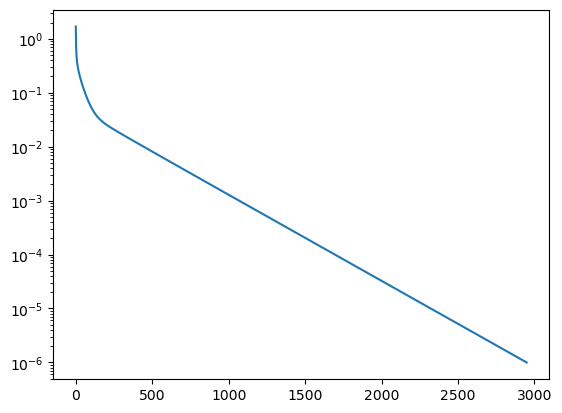

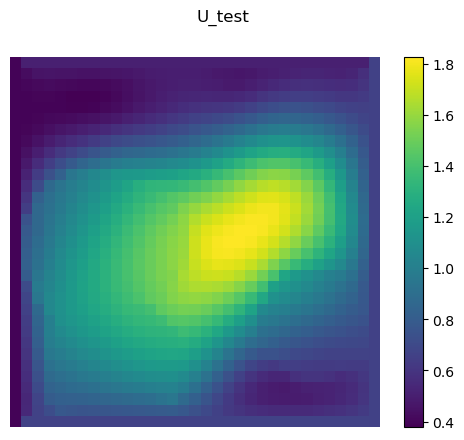

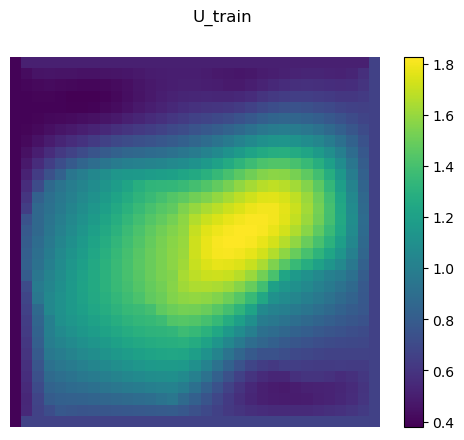

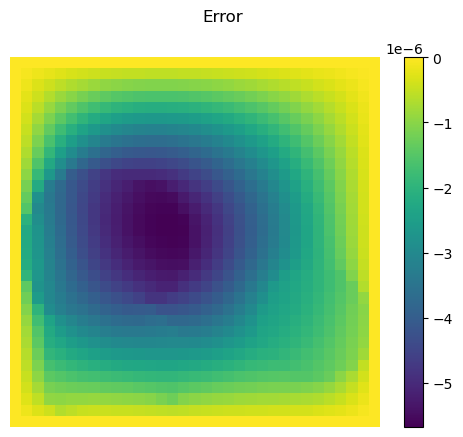

In [19]:
EPS = 1e-6
att_net.eval()
newnew_iterator = PsiIterator(device_predict, att_net=att_net, n=n_test, nb_layers=nb_layers, batch_size=1)

with torch.no_grad():
    n_jac = 0
    n = n_test
    h = 2./n
    u_test = torch.ones(size=(1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = newnew_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*newnew_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr = [res]

    print(n_jac, res)
    while (abs(res) > EPS):
        u_test = newnew_iterator.grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
        residual = d_idx_test*newnew_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

0 1.6908836206466953
1 1.787068230955414
2 2.7352670200830853
3 5.132955941275175
4 10.615341013298876
5 23.13915413667478
6 52.10534932370747
7 120.23660284679003
8 283.17935319211165
9 679.0000358629426
10 1653.8590861081277
11 4083.0844483507535
12 10195.136793884345
13 25694.11380286913
14 65244.08807315545
15 166676.76531308884
16 427878.5994212828
17 1102741.7628626907
18 2851165.2437377847
19 7391385.594080698
20 19204323.354274493
21 49991728.76107118
22 130349874.35036886
23 340366507.6598626
24 889886183.0797563
25 2329240245.0892587
26 6102909890.332056
27 16005190493.137115
28 42009776284.71893
29 110350617355.71756
30 290072936246.52045
31 762999235811.8982
32 2008188835261.2415
33 5288468714267.581
34 13934250874463.373
35 36732513150180.914
36 96876289543409.39
37 255606548979464.34
38 674688029088869.2
39 1781560194691282.5
40 4706036308658561.0
41 1.2435376018014142e+16
42 3.287030624387622e+16
43 8.691259069746038e+16
44 2.2987368721466538e+17
45 6.081594568074514e+17

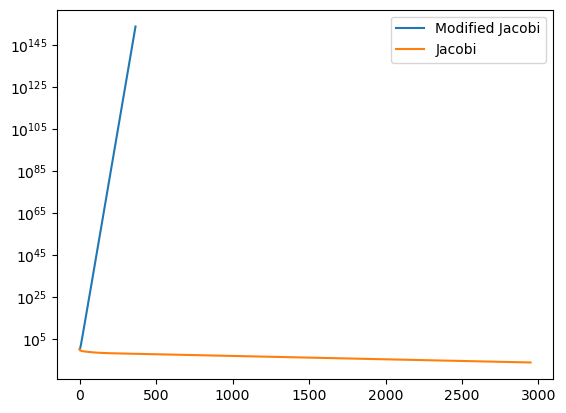

In [20]:
EPS = 1e-6
att_net.eval()
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = newnew_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*newnew_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS and n_new < 5000):
        u_test = newnew_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*newnew_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [21]:
att_net.eval()
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, attnet=new_iterator.att_net, nb_layers=nb_layers, device=device, iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 1.6908836206466953
1 0.437633750468909
2 0.1500868080487637
3 0.05720959928669326
4 0.031227923667223486
5 0.016507407860025376
6 0.009883120037789536
7 0.005751093505573487
8 0.003449323798171846
9 0.0020492671129949255
10 0.0012273377728912256
11 0.0007328622865696906
12 0.0004386929064442331
13 0.00026234396725393125
14 0.00015701964262427548
15 9.394983021420135e-05
16 5.623106670936104e-05
17 3.3652071295785216e-05
18 2.0141947716569202e-05
19 1.2055304770812376e-05
20 7.215678382819816e-06
21 4.318901783279928e-06
22 2.5851101477502765e-06
23 1.5473366955418997e-06
24 9.261789564155762e-07
Solution converges after 24 Jacobi multigrid iterations in 0.37548828125 seconds.


In [22]:
att_net.eval()
with torch.no_grad():
    h = 2./n
    n_mg_psi = 0
    mg_psi = MultiGrid(n=n, attnet=new_iterator.att_net, nb_layers=nb_layers, device=device, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_psi.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_psi.p_arr[0]['u0']
    residual = d_idx_test*mg_psi.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS and n_mg_psi < 1000):
        u_mg_psi = mg_psi.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_psi.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 1.6908836206466953
1 2.8941863352315984
2 12.115818052986533
3 66.94149678971205
4 394.56035472440846
5 2371.1250455769205
6 14382.549787954158
7 88000.37098455352
8 546693.5292192694
9 3476817.5044671125
10 22694131.90871434
11 151662029.83078492
12 1035372149.1105077
13 7192615894.925696
14 50357792851.56695
15 352047949416.649
16 2456294477226.146
17 17188533501451.855
18 120905645711529.55
19 856295373048009.1
20 6125327386552191.0
21 4.403661811648211e+16
22 3.142765135142487e+17
23 2.2211438260548163e+18
24 1.5713585771488571e+19
25 1.1195949239973768e+20
26 8.011461386136555e+20
27 5.769175993468931e+21
28 4.185766485134582e+22
29 3.0228922705707e+23
30 2.1542030952644666e+24
31 1.5312412668453707e+25
32 1.0988180820109437e+26
33 7.928933995273104e+26
34 5.736598505034884e+27
35 4.17999920753634e+28
36 3.0442387477218806e+29
37 2.187274665402377e+30
38 1.5599445878430008e+31
39 1.1222458366346685e+32
40 8.140320611662269e+32
41 5.911634624866179e+33
42 4.31395795287605e+34
43 

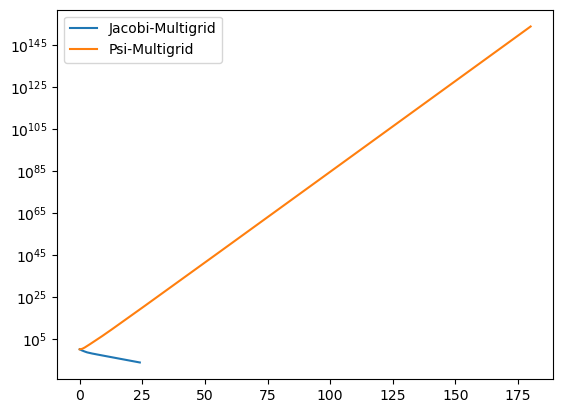

In [23]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

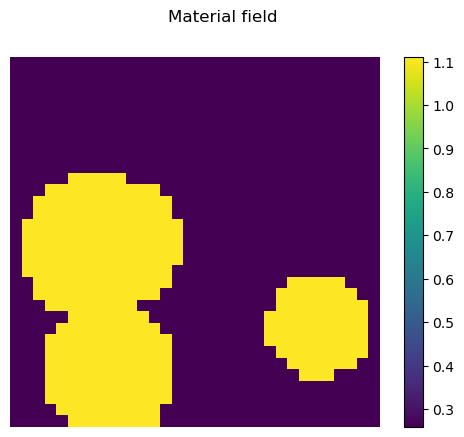

In [24]:
plot.plot_thermalfield(m_test.reshape(n, n), 'Material field')

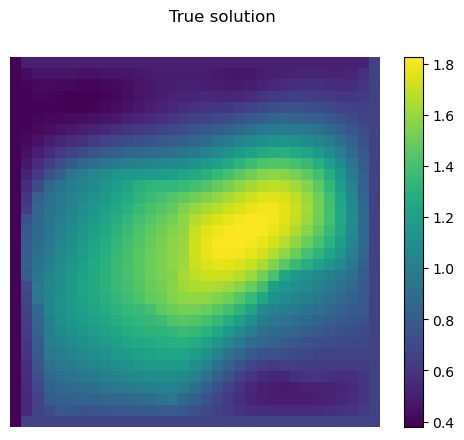

In [25]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

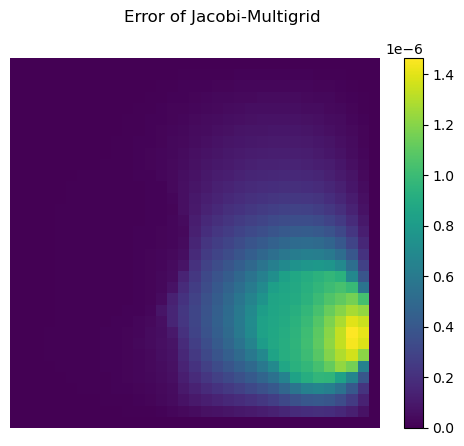

In [26]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [27]:
u_mg_jac-solution_test

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.1973e-11, -3.7221e-11,  ...,  4.9828e-09,
            2.4983e-09,  0.0000e+00],
          [ 0.0000e+00, -6.6371e-11, -6.3989e-11,  ...,  1.0210e-08,
            5.1601e-09,  0.0000e+00],
          ...,
          [ 0.0000e+00,  1.1035e-09,  2.3674e-09,  ...,  2.5726e-07,
            1.3850e-07,  0.0000e+00],
          [ 0.0000e+00,  5.8838e-10,  1.3107e-09,  ...,  1.2886e-07,
            7.0418e-08,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float64)

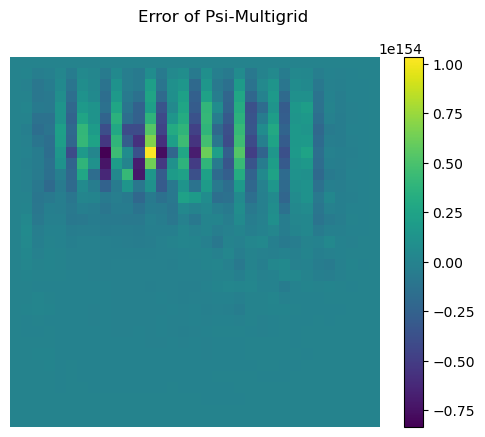

In [28]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [29]:
u_mg_psi.detach()-solution_test

tensor([[[[  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00],
          [  0.0000e+00,  7.0891e+151, -3.4870e+152,  ..., -3.7785e+151,
           -1.9872e+151,   0.0000e+00],
          [  0.0000e+00, -1.2874e+152, -9.2954e+152,  ..., -4.9558e+151,
           -3.8080e+151,   0.0000e+00],
          ...,
          [  0.0000e+00,  4.8977e+150,  1.8234e+151,  ..., -2.8491e+150,
           -1.6136e+150,   0.0000e+00],
          [  0.0000e+00, -4.4989e+150,  1.9913e+150,  ..., -1.7905e+150,
           -1.0295e+150,   0.0000e+00],
          [  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00]]]], device='cuda:0',
       dtype=torch.float64)